## Introduction

A customer is interested in opening an Italian restaurant in Newyork city and wants to know the best neighborhood for this. We will help him/her make the best decision with our datascience capabilities.

Obviously, we have to find out the neighborhoods that has least number of Italian restaurants or none at all.
We also will need location details of all the neighborhoods. Showing all these details in a map that will use the location details will be a best decision making tool!



In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py36h5fab9bb_0 --> 2020.12.5-py36h5fab9bb_1



geopy-2.1.0          | 64 KB     

<a id='item1'></a>


##  Dataset


We will need Neighborhood details like Boroughs, neighborhoods in each borough and their geo locations for this.
We will use these data to identify number of Italian restaurants per neighborhood. Based on this. we can then segment the neighborhoods by most to least promising ones.


For this excercise, I downloaded the NYC JSON from Skillsnetwork.


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data
type(newyork_data)

dict

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Print resulting dataframe.


In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Methodology

We will convert data into useable format, clean the data. We then will create interactive map of NYC with neighborhoods and show the number of existing Italian restaurants for each on pop-up.

Next we will cluster the neighborhoods by k-means based on number of Italian restaurants they have. Then generate an interactive map based on the custer. We will also analyse each cluster seperately.This will the customer in decision making.

#### Use geopy library to get the latitude and longitude values of New York City.


In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials without exposing them


In [114]:
import getpass
CLIENT_ID = getpass.getpass() # your Foursquare ID
CLIENT_SECRET = getpass.getpass()  # your Foursquare Secret
VERSION = '20190605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

 ················································
 ················································


First, let's create the GET request URL.


In [115]:
# get location details from FOURSQUARE
neighborhood_latitude=40.7127281; 
neighborhood_longitude=-74.0060152;
LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url

In [14]:
results = requests.get(url).json()

In [15]:
#results

In [16]:
venues = results['response']['groups'][0]['items']
venues[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '57f0689d498e7d49d9189369',
  'name': 'The Bar Room at Temple Court',
  'location': {'address': '123 Nassau St',
   'lat': 40.7114477287544,
   'lng': -74.00680157032005,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.7114477287544,
     'lng': -74.00680157032005}],
   'distance': 157,
   'postalCode': '10038',
   'cc': 'US',
   'neighborhood': 'Financial District',
   'city': 'New York',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['123 Nassau St',
    'New York, NY 10038',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1d5941735',
    'name': 'Hotel Bar',
    'pluralName': 'Hotel Bars',
    'shortName': 'Hotel Bar',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'gr

### normalize the JSON data and load into dataframe

In [17]:
nearby_venues = json_normalize(venues)
nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.neighborhood,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet,venue.venuePage.id,venue.delivery.id,venue.delivery.url,venue.delivery.provider.name,venue.delivery.provider.icon.prefix,venue.delivery.provider.icon.sizes,venue.delivery.provider.icon.name
0,e-0-57f0689d498e7d49d9189369-0,0,"[{'summary': 'This spot is popular', 'type': '...",57f0689d498e7d49d9189369,The Bar Room at Temple Court,123 Nassau St,40.711448,-74.006802,"[{'label': 'display', 'lat': 40.7114477287544,...",157,10038,US,Financial District,New York,NY,United States,"[123 Nassau St, New York, NY 10038, United Sta...","[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e-0-56d8c0f8498edb854f926e6a-1,0,"[{'summary': 'This spot is popular', 'type': '...",56d8c0f8498edb854f926e6a,"The Beekman, A Thompson Hotel",123 Nassau St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,NaN,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",0,[],Beekman St,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e-0-4c606c3e1e5cd13ad1a1a1ed-2,0,"[{'summary': 'This spot is popular', 'type': '...",4c606c3e1e5cd13ad1a1a1ed,Alba Dry Cleaner & Tailor,140 Nassau St,40.711434,-74.006272,"[{'label': 'display', 'lat': 40.71143355866638...",145,10038,US,NaN,New York,NY,United States,"[140 Nassau St (Beekman and Spruce st), New Yo...","[{'id': '4bf58dd8d48988d1fc941735', 'name': 'L...",0,[],Beekman and Spruce st,40218202,NaN,NaN,NaN,NaN,NaN,NaN
3,e-0-3fd66200f964a520d8f11ee3-3,0,"[{'summary': 'This spot is popular', 'type': '...",3fd66200f964a520d8f11ee3,City Hall Park,17 Park Row,40.711893,-74.007792,NaN,176,10038,US,NaN,New York,NY,United States,"[17 Park Row (btwn Broadway & Centre St), New ...","[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",0,[],btwn Broadway & Centre St,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e-0-53373f26498e940581c90985-4,0,"[{'summary': 'This spot is popular', 'type': '...",53373f26498e940581c90985,Gibney Dance Center Downtown,280 Broadway,40.713923,-74.005661,"[{'label': 'display', 'lat': 40.71392316324669...",136,10007,US,NaN,New York,NY,United States,"[280 Broadway (Chambers St), New York, NY 1000...","[{'id': '4bf58dd8d48988d134941735', 'name': 'D...",0,[],Chambers St,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,The Bar Room at Temple Court,"[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",40.711448,-74.006802
1,"The Beekman, A Thompson Hotel","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",40.711173,-74.006702
2,Alba Dry Cleaner & Tailor,"[{'id': '4bf58dd8d48988d1fc941735', 'name': 'L...",40.711434,-74.006272
3,City Hall Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",40.711893,-74.007792
4,Gibney Dance Center Downtown,"[{'id': '4bf58dd8d48988d134941735', 'name': 'D...",40.713923,-74.005661


In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
1,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
2,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272
3,City Hall Park,Park,40.711893,-74.007792
4,Gibney Dance Center Downtown,Dance Studio,40.713923,-74.005661


<a id='item2'></a>


#### Let's create a function to repeat the same process to all the neighborhoods in NYC


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'NeighborhoodLatitude', 
                  'NeighborhoodLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude',
                  'VenueCategory']
    
    return(nearby_venues)

In [22]:
# NYC neighborhoods
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Let's check the size of the resulting dataframe


In [23]:
print(ny_venues.shape)
ny_venues.head()

(10091, 7)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [24]:
#Italian Restaurant
IR_venues = ny_venues[ny_venues['VenueCategory']=='Italian Restaurant']
IR_venues.shape
IR_venues.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
162,Woodlawn,40.898273,-73.867315,Patrizia's Of Woodlawn,40.900638,-73.867724,Italian Restaurant
244,Pelham Parkway,40.857413,-73.854756,Enzo's,40.854232,-73.854362,Italian Restaurant
254,Pelham Parkway,40.857413,-73.854756,Pasta Pasta,40.854788,-73.854929,Italian Restaurant
269,City Island,40.847247,-73.786488,Artie's Steak and Seafood,40.849542,-73.787317,Italian Restaurant
299,Bedford Park,40.870185,-73.885512,Jolly Tinker,40.867451,-73.883536,Italian Restaurant


Let's check how many venues were returned for each neighborhood


In [25]:
IR_venuesgrouped =IR_venues.groupby('Neighborhood').count()
IR_venuesgrouped.head()

,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Arrochar,2,2,2,2,2,2
Astoria,2,2,2,2,2,2
Astoria Heights,1,1,1,1,1,1
Auburndale,2,2,2,2,2,2
Bath Beach,2,2,2,2,2,2


In [26]:
# merge IR_venuesgrouped with NYC neighborhoods.This gives Location for each neighborhood and Italian Restaurants in neighborhoods
ny_merged = pd.merge(neighborhoods,IR_venuesgrouped,how="left", on='Neighborhood')
ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Bronx,Wakefield,40.894705,-73.847201,NaN,NaN,NaN,NaN,NaN,NaN
1,Bronx,Co-op City,40.874294,-73.829939,NaN,NaN,NaN,NaN,NaN,NaN
2,Bronx,Eastchester,40.887556,-73.827806,NaN,NaN,NaN,NaN,NaN,NaN
3,Bronx,Fieldston,40.895437,-73.905643,NaN,NaN,NaN,NaN,NaN,NaN
4,Bronx,Riverdale,40.890834,-73.912585,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#Keep only required data
ny_merged = ny_merged[['Borough','Neighborhood','Latitude','Longitude','Venue']]
ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Venue
0,Bronx,Wakefield,40.894705,-73.847201,NaN
1,Bronx,Co-op City,40.874294,-73.829939,NaN
2,Bronx,Eastchester,40.887556,-73.827806,NaN
3,Bronx,Fieldston,40.895437,-73.905643,NaN
4,Bronx,Riverdale,40.890834,-73.912585,NaN


In [28]:
# Clean data. Replace NaN values with zeros
ny_merged_filled = ny_merged.fillna(0)
ny_merged_filled.head()

,Borough,Neighborhood,Latitude,Longitude,Venue
0,Bronx,Wakefield,40.894705,-73.847201,0.0
1,Bronx,Co-op City,40.874294,-73.829939,0.0
2,Bronx,Eastchester,40.887556,-73.827806,0.0
3,Bronx,Fieldston,40.895437,-73.905643,0.0
4,Bronx,Riverdale,40.890834,-73.912585,0.0


In [29]:
display(ny_merged_filled.dtypes)

Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
Venue           float64
dtype: object

In [30]:
# convert venues to int
ny_merged_filled['Venue'] = ny_merged_filled['Venue'].astype(int)
display(ny_merged_filled.dtypes)

Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
Venue             int64
dtype: object

In [31]:
ny_merged_filled.head()

,Borough,Neighborhood,Latitude,Longitude,Venue
0,Bronx,Wakefield,40.894705,-73.847201,0
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0


In [57]:
venues_by_borough = ny_merged_filled.groupby(['Borough'],as_index=False).sum()
venues_by_borough

,Borough,Latitude,Longitude,Venue
0,Bronx,2124.225053,-3841.418978,40
1,Brooklyn,2845.576249,-5176.709962,65
2,Manhattan,1630.497534,-2959.013164,119
3,Queens,3297.220358,-5979.754596,40
4,Staten Island,2557.097609,-4670.657086,44


In [53]:
#bar = venues_by_borough.plot.bar(x='Latitude',y='Venue',rot=0)
#bar

<bound method Axes.plot of <AxesSubplot:title={'center':'Italian Restaurants by Borough'}, xlabel='Boroughs', ylabel='Italian Restaurants'>>

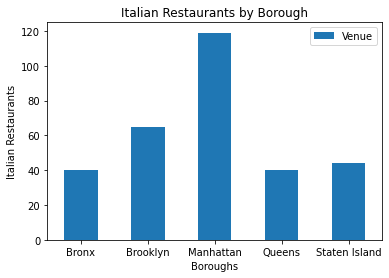

In [111]:
bar = venues_by_borough.plot.bar(x='Latitude',y='Venue',rot=0)
bar.set_title('Italian Restaurants by Borough')
bar.set_xlabel('Boroughs')
bar.set_ylabel('Italian Restaurants')
bar.set_xticklabels(venues_by_borough['Borough'],  fontsize=10)
bar.plot

### Generate NYC map with neighborhoods. Pop-up will display existing Italian restaurants.

This is an interactive map based on initial analysis of number of restaurants in each neighborhood.

In [112]:
#nyc lat long#
latitude=40.7127281;
longitude=-74.0060152;

In [113]:
# create map of NYC using latitude and longitude values and diplay number of Italian Restaurants in Pop up of neighborhood
map_details = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, brg, ngh, count in zip(ny_merged_filled['Latitude'], ny_merged_filled['Longitude'], ny_merged_filled['Borough'], ny_merged_filled['Neighborhood'], ny_merged_filled['Venue']):
    label = folium.Popup(brg+','+ngh+','+str(count), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='green',
        fill=True,
        fill_color=count*0.7,
        fill_opacity=count*0.7,
        parse_html=False).add_to(map_details)  
    
map_details

<a id='item3'></a>


### Onehot encode Neighborhoods data


In [61]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_merged_filled[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_merged_filled['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,Venue
0,Wakefield,0
1,Co-op City,0
2,Eastchester,0
3,Fieldston,0
4,Riverdale,0


Lets make sure we have all 306 neighborhoods


In [62]:
ny_onehot.shape

(306, 2)

#### Next, let's see number of unique Italian restaurant counts


In [ ]:
print('There are {} uniques categories.'.format(len(ny_onehot['Venue'].unique())))

<a id='item4'></a>


### Cluster Neighborhoods based on number of existing Italian Restaurants


Run _k_-means to cluster the neighborhood into 5.


In [63]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_onehot.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([3, 3, 3, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [64]:
# add clustering labels
ny_merged_filled.insert(0, 'Cluster Labels', kmeans.labels_)

In [65]:
ny_merged_filled.head()

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Venue
0,3,Bronx,Wakefield,40.894705,-73.847201,0
1,3,Bronx,Co-op City,40.874294,-73.829939,0
2,3,Bronx,Eastchester,40.887556,-73.827806,0
3,3,Bronx,Fieldston,40.895437,-73.905643,0
4,3,Bronx,Riverdale,40.890834,-73.912585,0


## Result

Based on location details and number of Italian restaurants already available, we are generating an interactive map that will group the nighborhoods and highlight them in different colors. The grouping is based on number of Italian restaurants available a key factor in our decision making. We will also analyze each group (cluster) in detail before we conculde.

Click on the neighborhoods (clustered by differect colors) to see number of existing Italian Restaurants

In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = ('orange','yellow','green','red','blue')
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,cnt in zip(ny_merged_filled['Latitude'], ny_merged_filled['Longitude'], ny_merged_filled['Neighborhood'], ny_merged_filled['Cluster Labels'], ny_merged_filled['Venue']):
    label = folium.Popup('ClusterId:'+str(cluster)+','+str(poi) +','+'Italian Restaurants:'+ str(cnt), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


### Examine each clusters


We can examine each cluster to see number Italian Restaurants that distinguish each cluster.

#### Neighborhoods where there is no Italian Restaurants. These are GREEN circle in the map above. These Neighborhoods are potentially best for opening Italian Restaurants.


In [78]:
ny_merged_filled.loc[ny_merged_filled['Cluster Labels'] == 3, ny_merged_filled.columns[[1] + list(range(2, ny_merged_filled.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Venue
0,Bronx,Wakefield,40.894705,-73.847201,0
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0
5,Bronx,Kingsbridge,40.881687,-73.902818,0
6,Manhattan,Marble Hill,40.876551,-73.910660,0
8,Bronx,Norwood,40.877224,-73.879391,0
9,Bronx,Williamsbridge,40.881039,-73.857446,0
10,Bronx,Baychester,40.866858,-73.835798,0


#### Neighborhoods having UPTO TWO Italian Restaurants. These neighborhoods, BLUE circle on above map, are promising too.


In [80]:
ny_merged_filled.loc[ny_merged_filled['Cluster Labels'] == 0, ny_merged_filled.columns[[1] + list(range(2, ny_merged_filled.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Venue
7,Bronx,Woodlawn,40.898273,-73.867315,1
11,Bronx,Pelham Parkway,40.857413,-73.854756,2
12,Bronx,City Island,40.847247,-73.786488,1
13,Bronx,Bedford Park,40.870185,-73.885512,1
28,Bronx,Throgs Neck,40.815109,-73.816350,1
30,Bronx,Parkchester,40.837938,-73.856003,1
33,Bronx,Morris Park,40.847549,-73.850402,1
36,Bronx,North Riverdale,40.908543,-73.904531,2
42,Bronx,Pelham Gardens,40.862966,-73.841612,1
43,Bronx,Concourse,40.834284,-73.915589,1


#### Neighborhoods having THREE to SIX Italian Restaurants. These neighborhoods, YELLOW circles on map, might be profitable if customer decides to open another one.


In [85]:
ny_merged_filled.loc[ny_merged_filled['Cluster Labels'] == 2, ny_merged_filled.columns[[1] + list(range(2, ny_merged_filled.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Venue
37,Bronx,Pelham Bay,40.850641,-73.832074,3
39,Bronx,Edgewater Park,40.821986,-73.813885,4
46,Brooklyn,Bay Ridge,40.625801,-74.030621,6
50,Brooklyn,Gravesend,40.595260,-73.973471,3
64,Brooklyn,Brooklyn Heights,40.695864,-73.993782,3
65,Brooklyn,Cobble Hill,40.687920,-73.998561,3
68,Brooklyn,Gowanus,40.673931,-73.994441,3
69,Brooklyn,Fort Greene,40.688527,-73.972906,4
70,Brooklyn,Park Slope,40.672321,-73.977050,3
84,Brooklyn,Clinton Hill,40.693229,-73.967843,5


#### Neighborhood having SEVEN to ELEVEN Italian Restaurants. These neighborhoods, ORANGE circles on map, might not be a good choice for opening another one.

In [86]:
ny_merged_filled.loc[ny_merged_filled['Cluster Labels'] == 1, ny_merged_filled.columns[[1] + list(range(2, ny_merged_filled.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Venue
66,Brooklyn,Carroll Gardens,40.680540,-73.994654,11
107,Manhattan,Upper East Side,40.775639,-73.960508,8
108,Manhattan,Yorkville,40.775930,-73.947118,9
109,Manhattan,Lenox Hill,40.768113,-73.958860,7
117,Manhattan,Greenwich Village,40.726933,-73.999914,10
122,Manhattan,Soho,40.722184,-74.000657,7
123,Manhattan,West Village,40.734434,-74.006180,11


#### Neighborhood having 12 OR MORE Italian Restaurants. These neighborhoods, RED circles on map, are not recommended.

In [87]:
ny_merged_filled.loc[ny_merged_filled['Cluster Labels'] == 4, ny_merged_filled.columns[[1] + list(range(2, ny_merged_filled.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Venue
34,Bronx,Belmont,40.857277,-73.888452,19


## Conclusion

From the interactive map above and each clusters, we identified the neighborhoods that does not have any existing Italian restaurants. These will be the most promising loactions for the customer.
